## **Unsupervised learning**
### Практика

In [2]:
import numpy                as np
import matplotlib.pyplot    as plt
import matplotlib.cm        as cm
import pandas               as pd
import ipywidgets           as widgets
from sklearn.decomposition  import PCA
import seaborn              as sns
import numpy                as np
from tqdm.notebook          import tqdm

from sklearn.cluster import \
    KMeans, \
    AgglomerativeClustering, \
    DBSCAN

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

### Задача 1

Рассмотрим датасет [**Leaf Classification**](https://www.kaggle.com/c/leaf-classification).

Данные содержат 1584 изображений образцов листьев (16 изображений для 99 видов). Размер некоторых изображений изменен, в результате чего все изображения имеют одинаковый размер $170×250$.



Загрузим все изображения с помощью `plt.imread` и визуализируем некоторые из них. Каждое изображение — матрица размера $170×250$.

In [5]:
!unzip /content/scaled_images.zip

Archive:  /content/scaled_images.zip
  inflating: scaled_images/1540.jpg  
  inflating: scaled_images/1573.jpg  
  inflating: scaled_images/1523.jpg  
  inflating: scaled_images/1538.jpg  
  inflating: scaled_images/1563.jpg  
  inflating: scaled_images/1543.jpg  
  inflating: scaled_images/1583.jpg  
  inflating: scaled_images/1576.jpg  
  inflating: scaled_images/1479.jpg  
  inflating: scaled_images/1517.jpg  
  inflating: scaled_images/1491.jpg  
  inflating: scaled_images/1572.jpg  
  inflating: scaled_images/1513.jpg  
  inflating: scaled_images/1529.jpg  
  inflating: scaled_images/1522.jpg  
  inflating: scaled_images/1541.jpg  
  inflating: scaled_images/1565.jpg  
  inflating: scaled_images/1470.jpg  
  inflating: scaled_images/1505.jpg  
  inflating: scaled_images/1514.jpg  
  inflating: scaled_images/1493.jpg  
  inflating: scaled_images/1539.jpg  
  inflating: scaled_images/1472.jpg  
  inflating: scaled_images/1554.jpg  
  inflating: scaled_images/1521.jpg  
  inflating: 

  0%|          | 0/1584 [00:00<?, ?it/s]

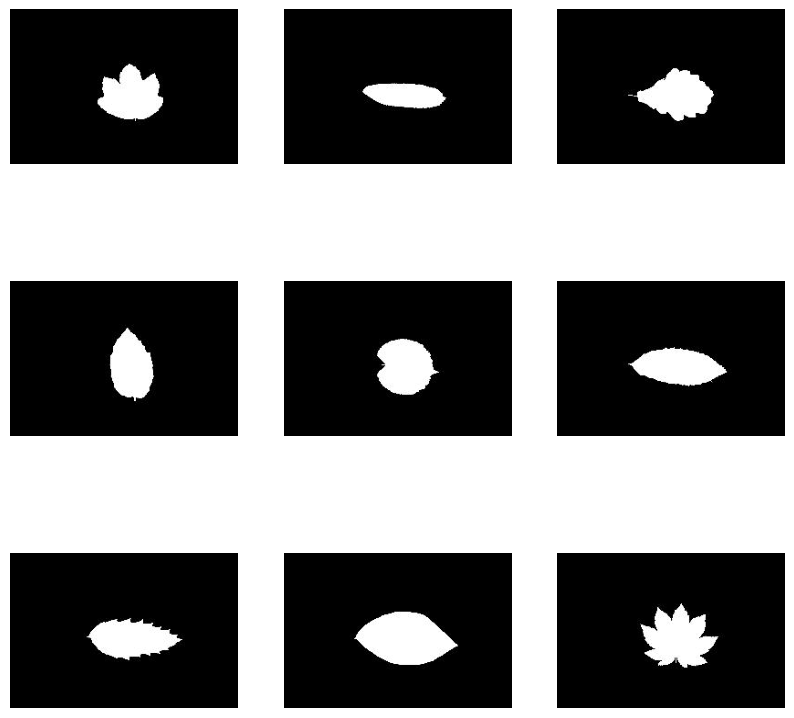

In [6]:
n_images = 1584
im_size = (170, 250)

X = []
for i in tqdm(range(n_images)):
    new_img = plt.imread('scaled_images/' + str(i + 1) + '.jpg')
    X.append(new_img)

X = np.array(X)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X[i], cmap='gray')
    plt.axis('off')
plt.show()

Сделаем также так, чтобы каждое изображение было представлено не матрицей, а одним вектором из всех пикселей

In [7]:
X = X.reshape(len(X), -1)
assert(X.shape ==(1584, 42500))

В файле `train_labels.csv` указаны номера образцов листьев, которые относятся к обучающей части данных, а также их виды.

In [10]:
labels = pd.read_csv('train_labels.csv')
labels.head(20)

id                species
0    1            Acer_Opalus
1    2  Pterocarya_Stenoptera
2    3   Quercus_Hartwissiana
3    5        Tilia_Tomentosa
4    6     Quercus_Variabilis
5    8   Magnolia_Salicifolia
6   10    Quercus_Canariensis
7   11          Quercus_Rubra
8   14        Quercus_Brantii
9   15         Salix_Fragilis
10  17        Zelkova_Serrata
11  18  Betula_Austrosinensis
12  20        Quercus_Pontica
13  21         Quercus_Afares
14  22      Quercus_Coccifera
15  25        Fagus_Sylvatica
16  26            Phildelphus
17  27          Acer_Palmatum
18  29      Quercus_Pubescens
19  30      Populus_Adenopoda

Разделите данные на обучающую и тестовую часть.

In [11]:
train_ids = np.array(labels.id)
test_ids = np.array(list(set(np.arange(1, len(X) + 1)) - set(train_ids)))

X_train, X_test = X[train_ids - 1], X[test_ids - 1]
y_train = labels

Отсортируем теперь по алфавиту названия видов и построим отображение строки в индекс.

In [12]:
species_names = sorted(np.unique(labels.species))
name_to_ind = dict([(name, i) for (i, name) in enumerate(species_names)])
labels.species = labels.species.map(name_to_ind)

На обучающей части данных построим 30 главных компонент.

**Пояснение**: доля объясненной дисперсии - это показатель, характеризующий какую долю от общей дисперсии в данных объясняет данная компонента. Почитайте в документации метода главных компонент о [`explained_variance_ratio_`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#:~:text=in%20version%200.18.-,explained_variance_ratio_,-ndarray%20of%20shape).

### **PCA (Principal Components Analysis)**

**I. Постановка задачи**

$$x_1, ..., x_n \rightarrow g_1, ..., g_k, \; k \leq n$$
$$U: UU^T = I, G = XU$$
$$\hat{X} = GU^T \approx X$$
$$||GU^T - X|| \rightarrow min_{G, U} \; s.t. rank(G) \leq k$$

**II. SVD (Singular value decomposition)**

$$||GU^T - X|| \rightarrow min_{G, U} \; s.t. rank(G) \leq k$$
$$X = V \Sigma U^T: ||GU^T - V \Sigma U^T||_2 = ||G - V \Sigma||_2$$
$$G = V \Sigma^{'}: ||V \Sigma^{'} - V \Sigma||_2 = ||\Sigma^{'} - \Sigma||_2$$
$$||A||_2 = \sigma_{max}(A): ||\Sigma^{'} - \Sigma||_2 = \sigma_k(\Sigma) = \sigma_k(X)$$

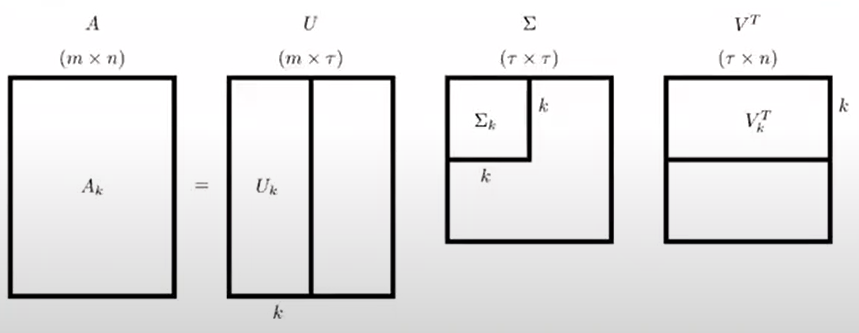

**III. Another approach**

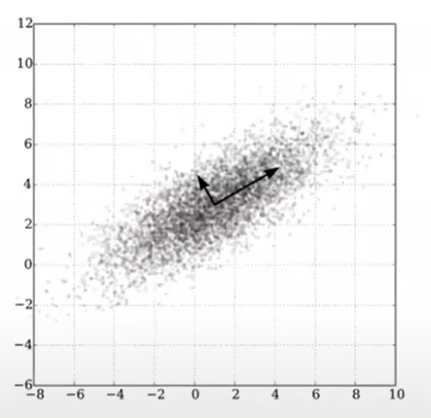

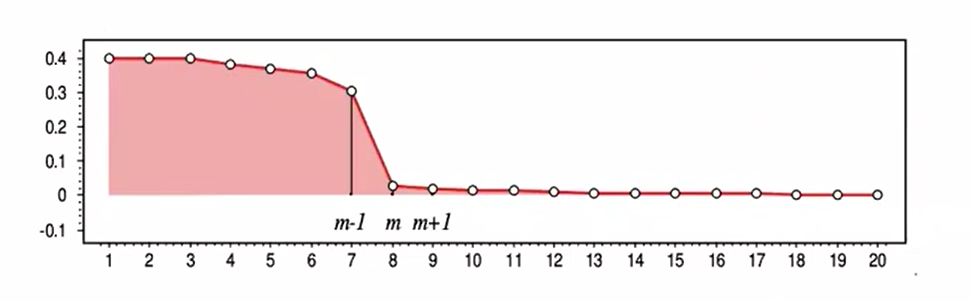

$$E_m = \frac{||GU^T - F||^2}{||F||^2} = \frac{\lambda_{m+1} + ... + \lambda_{n}}{\lambda_{1} + ... + \lambda_{n}} \leq \varepsilon$$

In [13]:
from sklearn.preprocessing import StandardScaler
pca = PCA(30)
X_pca = pca.fit_transform(X_train)

0.7764680807667739

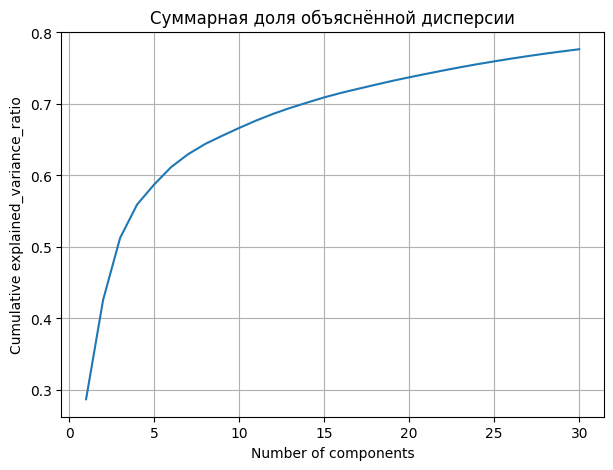

In [14]:
plt.figure(figsize=(7, 5))

plt.plot(np.arange(1, 31), np.cumsum(pca.explained_variance_ratio_))

plt.title("Суммарная доля объяснённой дисперсии")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained_variance_ratio")

plt.grid()

np.cumsum(pca.explained_variance_ratio_)[-1]

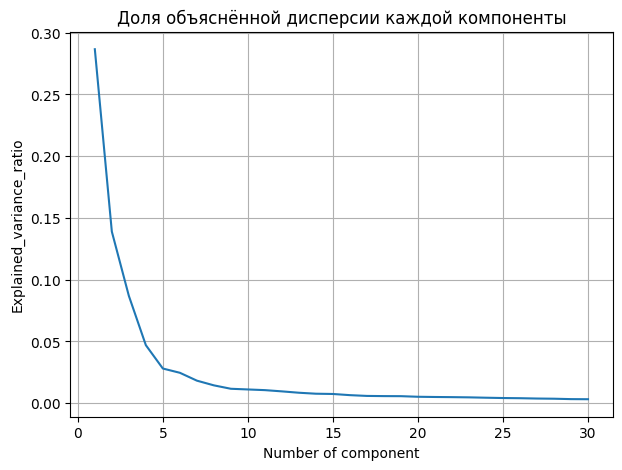

In [15]:
plt.figure(figsize=(7, 5))

plt.plot(np.arange(1, 31), pca.explained_variance_ratio_)

plt.title("Доля объяснённой дисперсии каждой компоненты")
plt.xlabel("Number of component")
plt.ylabel("Explained_variance_ratio")

plt.grid()

**Вывод:**

Видим, что суммарно первые 30 компонент описывают примерно 80% всей дисперсии.

Наибольший вклад вносит первая компонента. После 10-й компоненты вклад каждой новой стремится к нулю.

Визуализируем главные компоненты: покажем, какие картинки из себя представляют главные компоненты. Для этого перейдем обратно из представления изображения в виде одного длинного вектора к матрице.

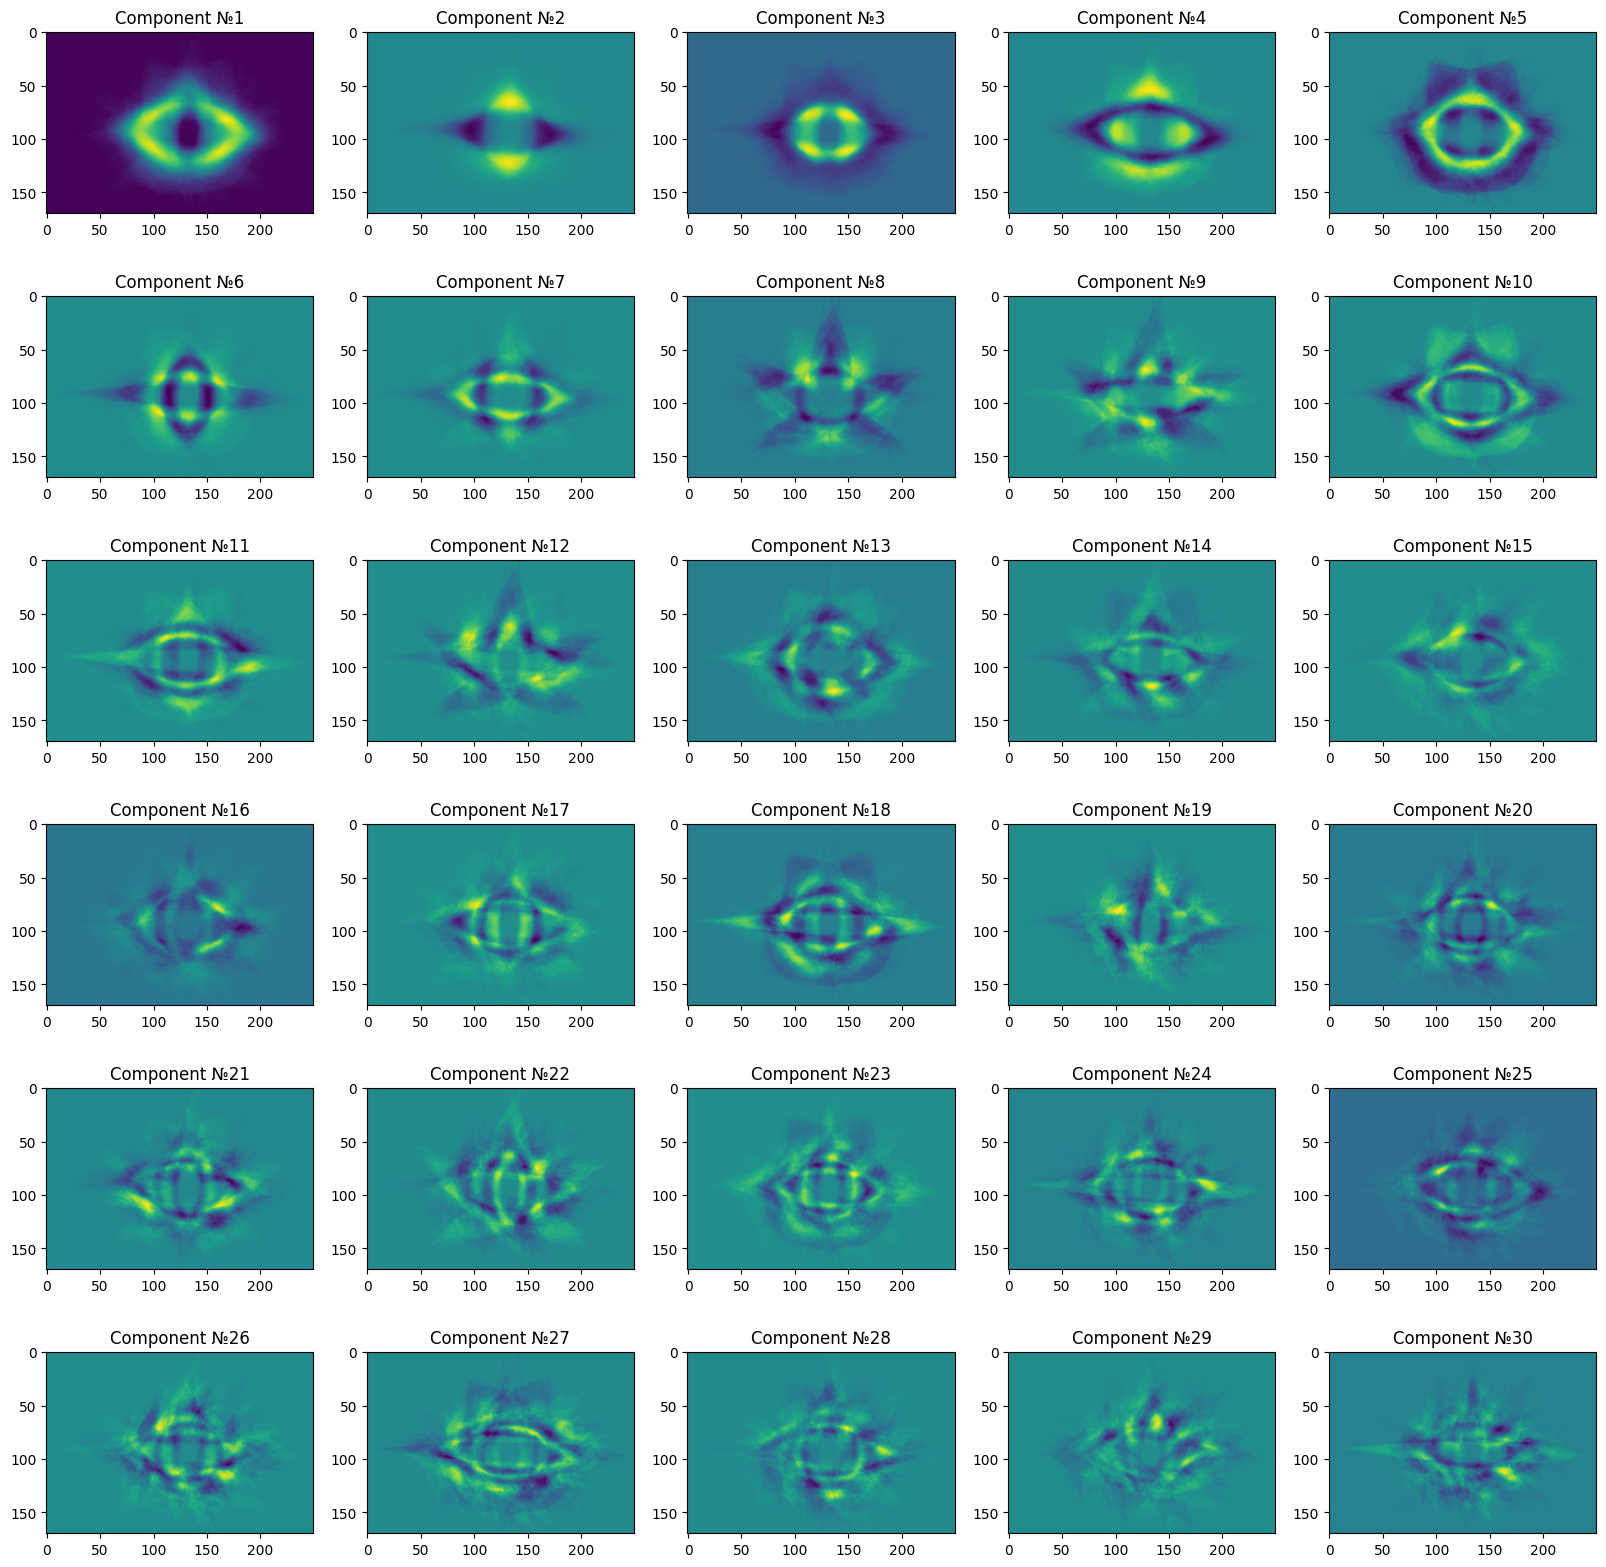

In [16]:
fig, axs = plt.subplots(figsize=(20, 20), ncols=5, nrows=6)
for i in range(6):
    for j in range(5):
        axs[i][j].imshow(pca.components_[5*i + j].reshape(170, 250))
        axs[i][j].set_title(f"Component №{5*i + j + 1}")

**Вывод:**

Для каждой компоненты видно некое усреднение всех форм листа с преобладанием одной из форм: какие-то горизонтально вытянуты, какие-то вертикально, какие-то звёздчатой формы.

Визуализируем обучающую часть данных в проекции на две первых главных компоненты. Цвет точки должен соответствовать виду образца. Используем `cmap=’Set1’` во избежание градации цвета по номеру вида.

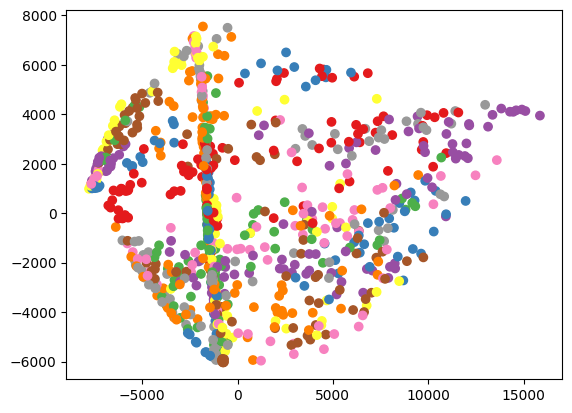

In [17]:
pc1, pc2 = X_pca[:, 0], X_pca[:, 1]
plt.scatter(pc1, pc2, c=labels.species, cmap='Set1')

**Вывод:**

Какие-то закономерности видны, но сомнительно...

Красные точечки явно примерно на одной линии, остальные тоже образуют условно связные области. Но никаких красивых кластеров.

По проекциям данных на первые 30 главных компонент обучите многоклассовую классификацию.

Используем любую модель классификации, рассмотренную на нашем курсе.

Разделим данные на тренировочную и валидационную выборки и проверим качество этой модели по метрике accuracy. Так как метки классов известны только для части данных, используйте только их. Сравним с результатом без применения PCA. 

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score as accuracy
from sklearn.ensemble import RandomForestClassifier

In [20]:
train_ftrs, test_ftrs, train_lbls, test_lbls = train_test_split(X_pca, labels.species, test_size=0.25)

lr = RandomForestClassifier()
lr.fit(train_ftrs, train_lbls)
preds = lr.predict(test_ftrs)

print("Accuracy with PCA: ", accuracy(test_lbls, preds))

Accuracy with PCA:  0.5443548387096774


In [21]:
scaler = StandardScaler()

train_ftrs, test_ftrs, train_lbls, test_lbls = train_test_split(X_train, labels.species, test_size=0.25)

X_s = scaler.fit_transform(train_ftrs)
X_ts = scaler.transform(test_ftrs)
X_s.shape

(742, 42500)

In [22]:
lr = RandomForestClassifier()
lr.fit(X_s, train_lbls)
preds = lr.predict(X_ts)

print("Accuracy without PCA: ",accuracy(test_lbls, preds))

Accuracy without PCA:  0.5120967741935484


**Вывод:**

Когда у нас размерность 42500, PCA явно поможет. И он помог. Метрика модели на главных компонентах выше, чем просто на исходном датасете.

In [23]:
labels

id  species
0       1        3
1       2       49
2       3       65
3       5       94
4       6       84
..    ...      ...
985  1575       40
986  1578        5
987  1581       11
988  1582       78
989  1584       50

[990 rows x 2 columns]

### Задача 2

В кишечнике человека живут триллионы микроорганизмов. Они могут влиять на совершенно различные процессы в организме. Однако на данный момент мы находимся лишь в самом начале пути изучения  механизмов их взаимодействия с организмом хозяина. Сейчас влияние микробиоты изучают во многих сферах медицины: в онкологии, психиатрии...

Состави микробиоты у каждого человека свой. Однако важна не только похожесть состава, но и функции тех или иных организмов, в частности белки, которые они производят. Весьма много информации могут нам дать данные [метагеномного секвенирования](https://www.news-medical.net/life-sciences/Shotgun-Metagenomic-Sequencing.aspx). Этот тип секвенирования позволяет получать короткие последовательности ДНК от всех организмов в образце вместе, то есть не разделяя ДНК по организмам. Использование метагеномного секвнирования помогло обнаружить, насколько распространены гены антибиотиков в наших кишечных бактериях.

На данный момент мы остановимся лишь на изучении того, какие организмы живут в кишечнике различных людей, а не на их функциях. Эти данные можно получить из данных метагеномного секвенирования, рассмотрев различные последовательности ДНК, соответствующие одной из субъединиц рибосомы. Оказывается, что по эти последовательности уникальны у каждого вида, и таким образом легко понять, какие микроорганизмы присутствуют в образце.

Скачаем [датасет](https://www.kaggle.com/antaresnyc/human-metagenomics?select=abundance_stoolsubset.csv). Мы будем использовать файл `abundance_stoolsubset.csv`, в котором лежат уже предобработанные данные о том, ДНК каких организмов обнаружена в образцах микробиоты кишечника и в каком количестве.

Данные были взяты из статьи
["Machine Learning Meta-analysis of Large Metagenomic Datasets: Tools and Biological Insights"
](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004977) Pasolli et al.


In [24]:
!unzip /content/archive.zip

Archive:  /content/archive.zip
  inflating: abundance.csv           
  inflating: abundance_stoolsubset.csv  
  inflating: marker_presence.csv     
  inflating: markers2clades_DB.csv   


In [25]:
data = pd.read_csv("abundance_stoolsubset.csv")
data.head()

<ipython-input-25-071de0c0be3a>:1: DtypeWarning: Columns (5,20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("abundance_stoolsubset.csv")


dataset_name sampleID subjectID bodysite disease age  gender   country  \
0  Candela_Africa      H10       h10    stool       n  40  female  tanzania   
1  Candela_Africa      H11       h11    stool       n  29  female  tanzania   
2  Candela_Africa      H12       h12    stool       n   8  female  tanzania   
3  Candela_Africa      H13       h13    stool       n  34    male  tanzania   
4  Candela_Africa      H14       h14    stool       n  30    male  tanzania   

  sequencing_technology  pubmedid  ...  \
0              Illumina  25981789  ...   
1              Illumina  25981789  ...   
2              Illumina  25981789  ...   
3              Illumina  25981789  ...   
4              Illumina  25981789  ...   

  k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_gilvus|t__Enterococcus_gilvus_unclassified  \
0                                                0.0                                                                                                      
1                                                0.0                                                                                                      
2                                                0.0                                                                                                      
3                                                0.0                                                                                                      
4                                                0.0                                                                                                      

  k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_otakiensis  \
0                                                0.0                                                                         
1                                                0.0                                                                         
2                                                0.0                                                                         
3                                                0.0                                                                         
4                                                0.0                                                                         

  k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_otakiensis|t__GCF_000415925  \
0                                                0.0                                                                                          
1                                                0.0                                                                                          
2                                                0.0                                                                                          
3                                                0.0                                                                                          
4                                                0.0                                                                                          

  k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae  \
0                                                0.0                           
1                                                0.0                           
2                                                0.0                           
3                                                0.0                           
4                                                0.0                           

  k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae|g__Desulfotomaculum  \
0                                                0.0                                               
1                                                

В данных есть много метаданных об образце. Их мы использовать не будем, так как хотим сравнивать людей по микроорганизмам.

Метаданные занимают первые 210 колонок. Удалим их.

In [165]:
data_clean = data.iloc[:, 210:]
data_clean.head()

k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_noname|o__Oscillatoriales|f__Oscillatoriales_noname|g__Microcoleus|s__Microcoleus_unclassified  \
0                                            0.01178                                                                                              
1                                            0.00000                                                                                              
2                                            0.00000                                                                                              
3                                            0.00000                                                                                              
4                                            0.00000                                                                                              

   k__Bacteria|p__Firmicutes  k__Bacteria|p__Firmicutes|c__Bacilli  \
0                   42.47285                               0.65540   
1                   38.21018                               0.15154   
2                   40.22336                               0.76707   
3                   54.82203                               0.00000   
4                   64.07312                               0.00000   

   k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales  \
0                                            0.65540         
1                                            0.15154         
2                                            0.76707         
3                                            0.00000         
4                                            0.00000         

   k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae  \
0                                            0.00823                              
1                                            0.00000                              
2                                            0.00000                              
3                                            0.00000                              
4                                            0.00000                              

   k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae|g__Granulicatella  \
0                                            0.00823                                                
1                                            0.00000                                                
2                                            0.00000                                                
3                                            0.00000                                                
4                                            0.00000                                                

   k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae|g__Granulicatella|s__Granulicatella_unclassified  \
0                                            0.00823                                                                               
1                                            0.00000                                                                               
2                                            0.00000                                                                               
3                                            0.00000                                                                               
4                                            0.00000                                                                               

   k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae  \
0                                                0.0                            
1                                                0.0                            
2                                                0.0                            
3                                                0.0                            
4                     

Если посмотреть на данные, то можно заметить, что учитываются как количества ДНК организмов каждого вида, так и более высших иерархических единиц. Таким образом, в данных присутствует избыточность, так как некоторые столбцы просто являются линейной комбинацией друг друга.

Снизим размерность с помощью PCA. Подберем оптимальное количество главных компонент.

In [166]:
pca = PCA()
X_pca = pca.fit_transform(data_clean)

# Подбираем оптимальное количество главных компонент
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# Находим оптимальное количество компонент, которые объясняют > 90% дисперсии
optimal_components = (cumulative_variance >= 0.9).argmax() + 1
print(f"Оптимальное количество главных компонент: {optimal_components}")

Оптимальное количество главных компонент: 16


Визуализируем данные с помощью t-SNE и UMAP. Используем особенности методов.

In [36]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.8 MB/s eta 0:00:00


In [167]:
from sklearn.manifold import TSNE
from umap.umap_ import UMAP
sns.set_style('white')

X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_pca[:, :optimal_components])
X_umap = UMAP(n_components=2, random_state=42).fit_transform(X_pca[:, :optimal_components])

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [174]:
def draw_umap_tsne(figsize, c=None, outliers=np.zeros(X_tsne.shape[0], dtype=bool)):
    """Функция, строящая проекции данных на 2 компоненты, получающиеся в результате применения UMAP

    Args:
        figsize: размер картинки
        c: метки для отображения точек в цвете.
        outliers: выбросы, если таковые имеются
    """
    # t-SNE
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.scatter(X_tsne[~outliers, 0], X_tsne[~outliers, 1], c=c, cmap='viridis', s=30)  # Объекты, не являющиеся выбросами
    plt.scatter(X_tsne[outliers, 0], X_tsne[outliers, 1], color='r', s=30, label='Outliers')  # Отдельно рисуем выбросы, если такие есть
    plt.xlabel('Координата 1')
    plt.ylabel('Координата 2')
    plt.title('TSNE: Данные в латентном пространстве')

    # UMAP
    plt.subplot(1, 2, 2)
    plt.scatter(X_umap[~outliers, 0], X_umap[~outliers, 1], c=c, cmap='viridis', s=30)  # Объекты, не являющиеся выбросами
    plt.scatter(X_umap[outliers, 0], X_umap[outliers, 1], color='r', s=300, label='Outliers')  # Отдельно рисуем выбросы, если такие есть
    plt.xlabel('Координата 1')
    plt.ylabel('Координата 2')
    plt.title('UMAP: Данные в латентном пространстве')
    plt.tight_layout()
    plt.show()

<ipython-input-174-5e1be649562c>:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_tsne[~outliers, 0], X_tsne[~outliers, 1], c=c, cmap='viridis', s=30)  # Объекты, не являющиеся выбросами
<ipython-input-174-5e1be649562c>:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_umap[~outliers, 0], X_umap[~outliers, 1], c=c, cmap='viridis', s=30)  # Объекты, не являющиеся выбросами


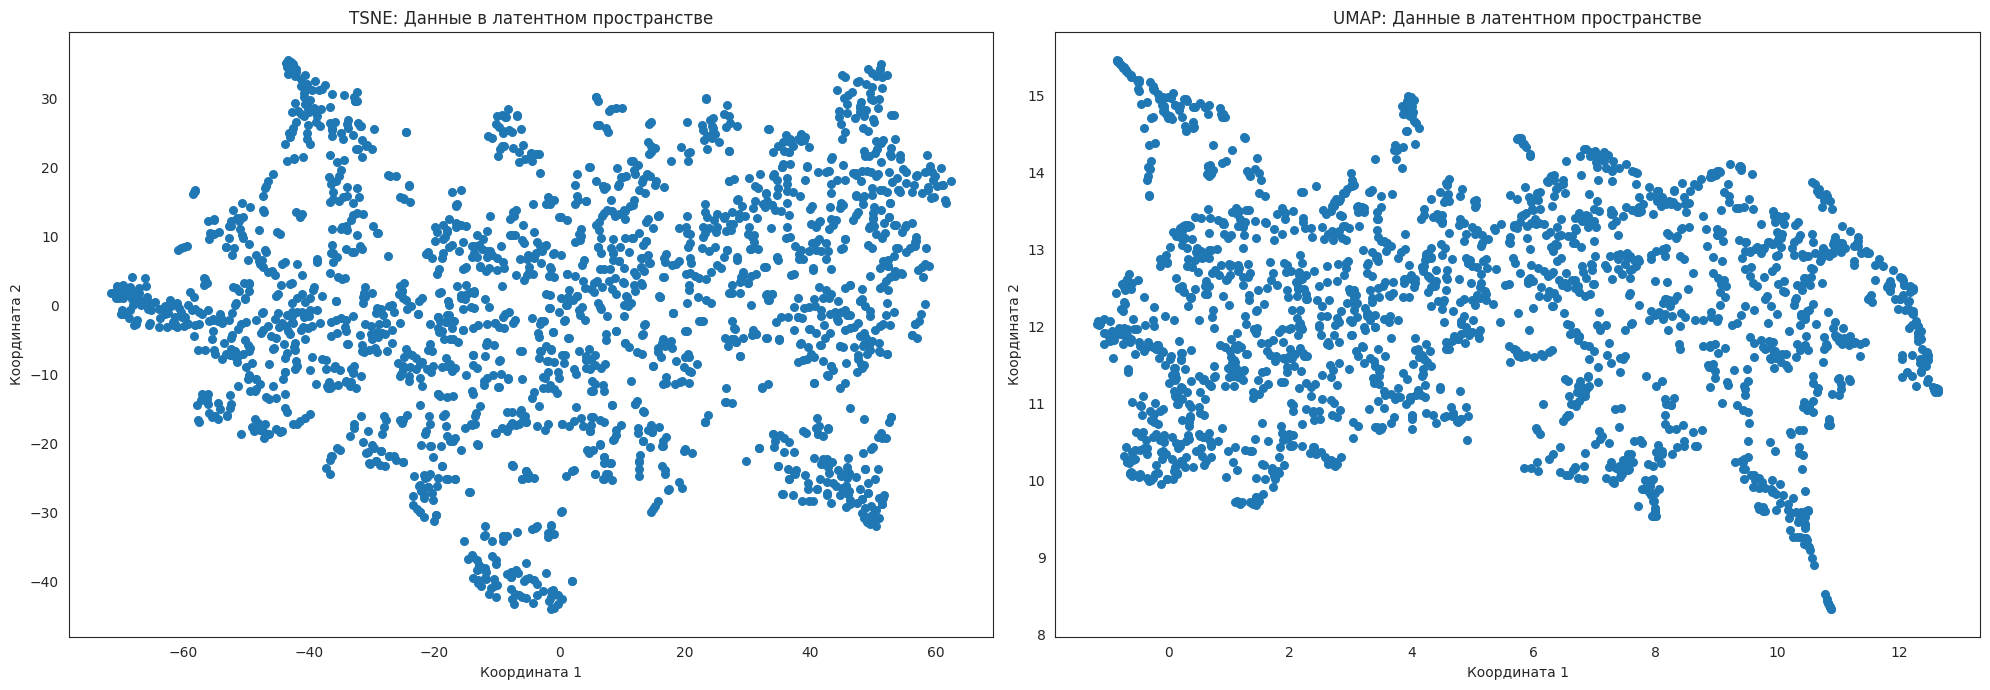

In [175]:
draw_umap_tsne(figsize=(20, 7))

Теперь перейдем к кластеризации. Попробуем кластеризовать данные в исходном пространстве и в пространстве после применения PCA с помощью DBSCAN, k-means и агломеративной кластеризации. Визуализируем полученные результаты кластеризации с помощью t-SNE и UMAP, выделяя разные кластеры цветом. В этом может помочь аргумент `c` метода `scatter`. Помимо этого, визуализируем силуэты точек. Вспомогательный код  для этого можно найти в [документации sklearn](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#selecting-the-number-of-clusters-with-silhouette-analysis-on-kmeans-clustering). 

В силу ограниченности времени - это не полноценное исследование, а всего лишь упражнение. Поэтому без особого погружения в предметную оюласть укажем какие методы, на наш взгляд, могут иметь потенциал при изучении данной темы, а какие стоит отбросить на начальном этапе.

In [176]:
# Стандартизация данных перед кластеризацией
X_scaled = StandardScaler().fit_transform(X_pca[:, :optimal_components])

In [200]:
from sklearn.metrics import silhouette_score, silhouette_samples

def silhouette_visualize(X, cluster_labels, figsize):
    """Функция для визуализации силуэтов кластеров.

    Args:
        X: данные
        cluster_labels: метки кластеров
        figsize: размер изображения
    """
    silhouette_vals = silhouette_samples(X, cluster_labels)
    silhouette_avg = silhouette_score(X, cluster_labels)

    y_lower = 10
    unique_labels = np.unique(cluster_labels)
    plt.figure(figsize=figsize)

    # Для каждого кластера рисуем силуэты
    for i, label in enumerate(unique_labels):
        if label == -1:
            continue  # Пропускаем выбросы, если такие есть

        cluster_silhouette_vals = silhouette_vals[cluster_labels == label]
        cluster_silhouette_vals.sort()

        cluster_size = cluster_silhouette_vals.shape[0]
        y_upper = y_lower + cluster_size

        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, cluster_silhouette_vals,
                          alpha=0.7)

        y_lower = y_upper + 10

    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.title("Silhouette Analysis")
    plt.xlabel("Silhouette Coefficient")
    plt.ylabel("Cluster")
    plt.show()

**DBSCAN**

In [201]:
def DBSCAN_visualize(eps, min_samples):
    """Функция для визуализации работы DBSCAN

    Args:
        eps и min_samples: гиперпараметры алгоритма
    """
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_scaled)

    # Визуализация результатов кластеризации
    draw_umap_tsne(figsize=(20, 7), c=labels)

    # Выводим силуэтный коэффициент, если кластеры обнаружены
    if len(np.unique(labels)) > 1:
        silhouette_visualize(X_scaled, labels, figsize=(10, 6))
        silhouette_avg = silhouette_score(X_scaled, labels)
        print(f"Silhouette Score for DBSCAN: {silhouette_avg}")
    else:
        print("No clusters found by DBSCAN.")

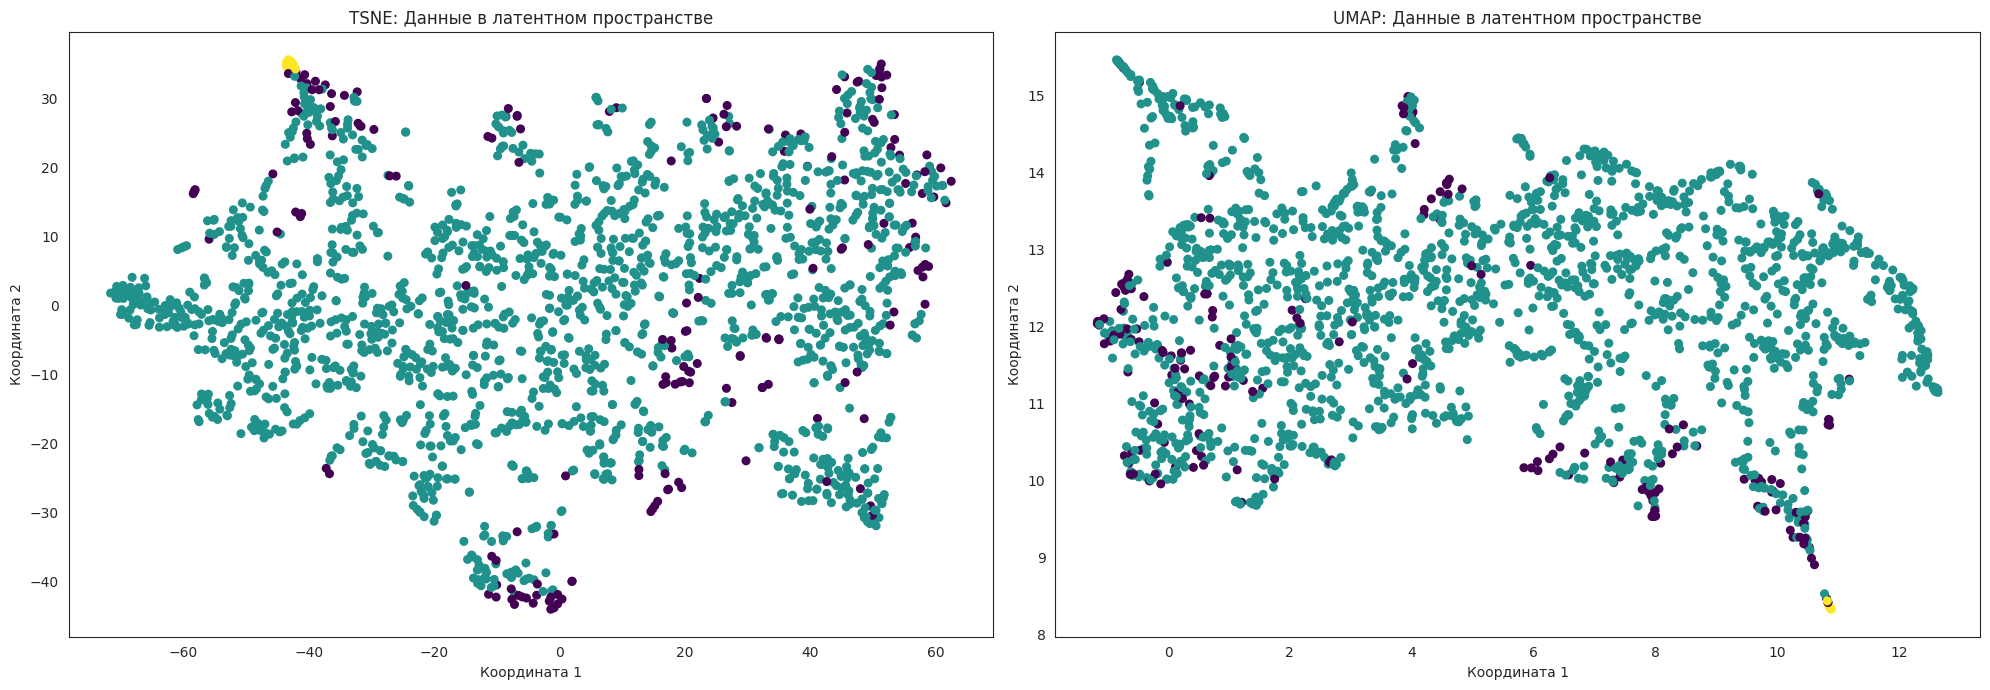

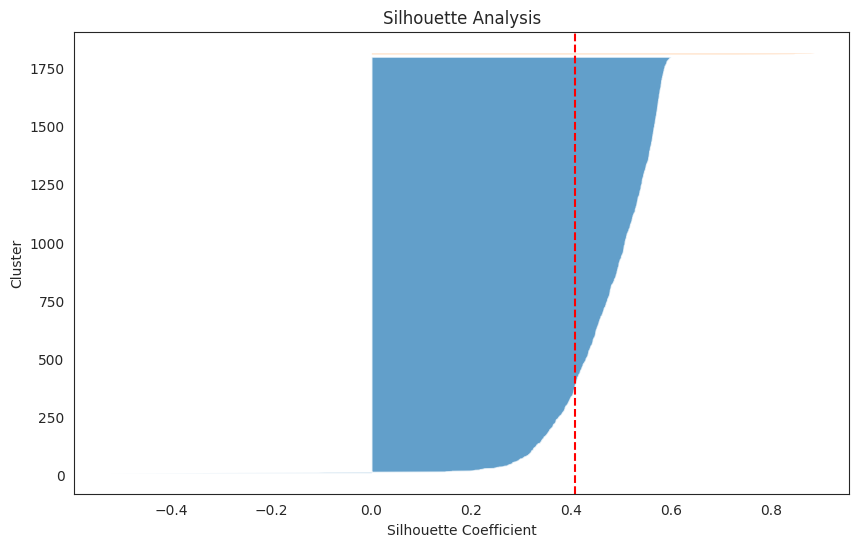

Silhouette Score for DBSCAN: 0.40764345296862653


In [220]:
DBSCAN_visualize(eps=2.5, min_samples=5)

**Вывод:**

**Параметры:** eps = 2.5, min_samples = 5.

**Silhouette Score:** 0.4076 — самый высокий среди всех алгоритмов, что указывает на лучшую плотность и однородность кластеров по сравнению с другими методами.

**Анализ результатов:** DBSCAN смог разделить данные на несколько плотных кластеров с высоким качеством по силуэтному коэффициенту. Это показывает, что DBSCAN хорошо справляется с задачей, когда данные имеют плотные группы и выбросы.

**Заключение:** DBSCAN демонстрирует наилучшие результаты среди всех методов в исходном пространстве данных и, вероятно, будет перспективен для дальнейших исследований. Однако параметр eps нужно точно настраивать для разных данных. А вот это очень муторно... Метод хороший, сам подбирает число кластеров, но вот подбор параметров - очень тонкий процесс.

**Agglomerative Clustering**

Для агломеративной кластеризации также постройте дендрограмму. Какого размера получаются кластеры?  Поясните по дендрограмме.

In [103]:
from scipy.cluster.hierarchy import dendrogram

In [204]:
def agglo_visualize(n_clusters):
    """Функция для визуализации работы агломеративной кластеризаии

    Args:
        n_clusters: количество кластеров
    """
    agglo = AgglomerativeClustering(n_clusters=n_clusters)
    labels = agglo.fit_predict(X_scaled)

    draw_umap_tsne(figsize=(20, 7), c=labels)
    silhouette_visualize(X_scaled, labels, figsize=(10, 6))
    silhouette_avg = silhouette_score(X_scaled, labels)
    print(f"Silhouette Score for Agglomerative Clustering: {silhouette_avg}")

    plt.figure(figsize=(10, 7))
    linkage_matrix = linkage(X_scaled, method='ward')
    dendrogram(linkage_matrix, truncate_mode='level', p=5)
    plt.title("Dendrogram for Agglomerative Clustering")
    plt.xlabel("Sample Index")
    plt.ylabel("Distance")
    plt.show()

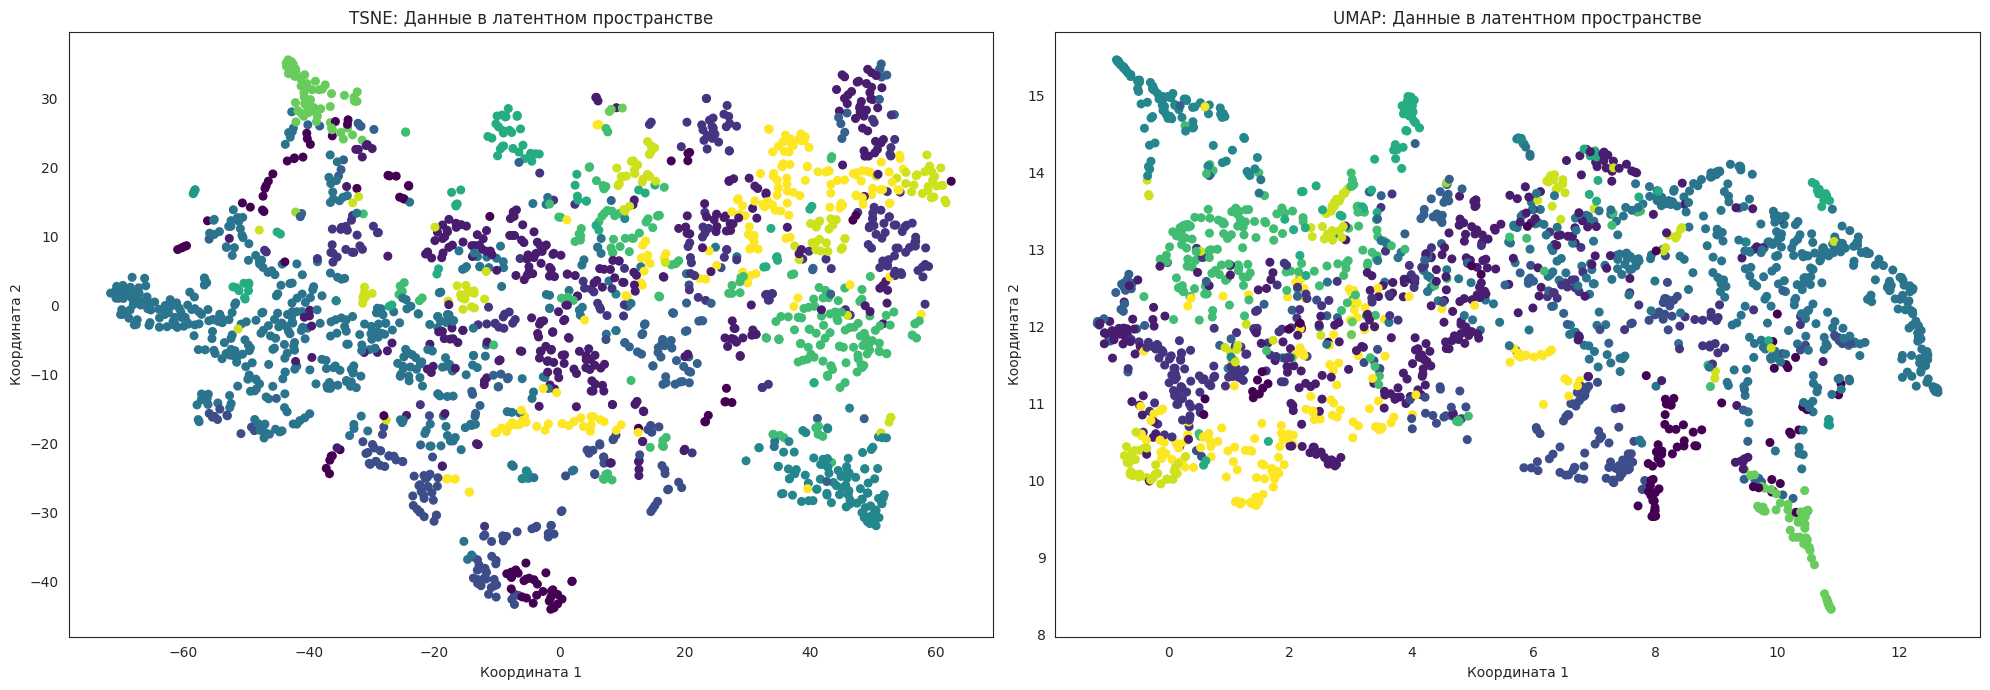

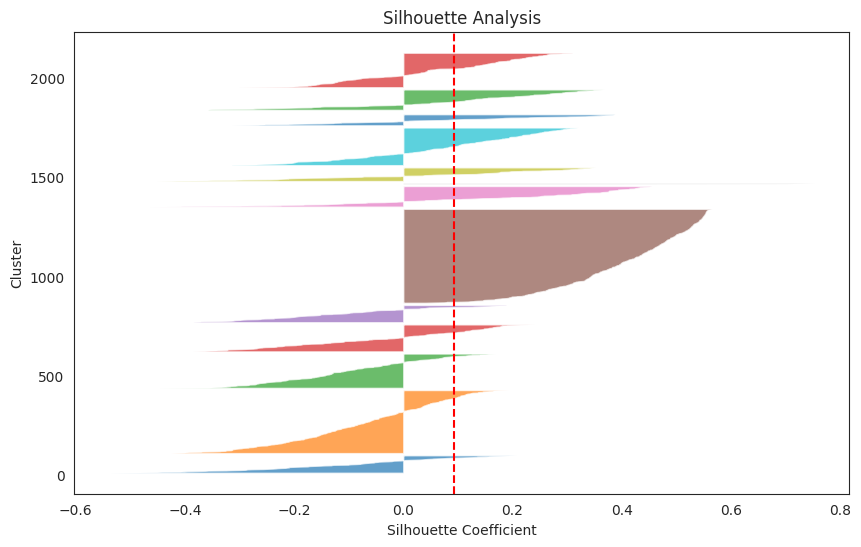

Silhouette Score for Agglomerative Clustering: 0.0936534113080568


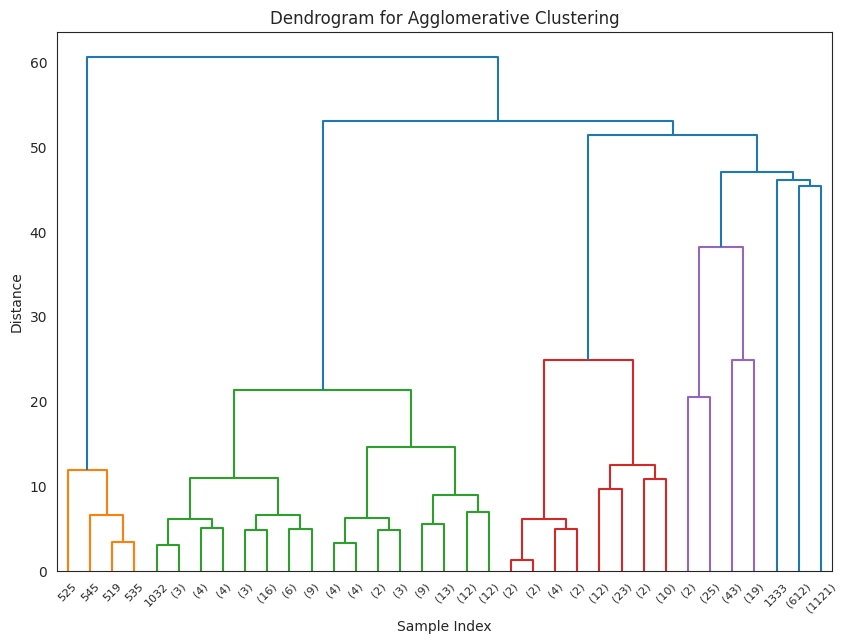

In [219]:
agglo_visualize(n_clusters=14)

**Вывод:**

**Параметры:** n_clusters = 14.

**Silhouette Score:** 0.0937 — самый низкий среди всех алгоритмов, что свидетельствует о слабой плотности и разделении кластеров.

**Анализ результатов:** Иерархическая кластеризация с фиксированным числом кластеров дала более размытые кластеры, что также видно на силуэтной диаграмме. Слабое разделение может быть связано с применением метода Ward, который минимизирует внутрикластерную дисперсию, но не всегда подходит для структур, в которых кластеры имеют разную плотность.

**Заключение:** Иерархическая кластеризация может быть менее эффективна на этом наборе данных. Возможно, ее стоит использовать в других представлениях данных или с иными методами связности. Также стоит учесть, то сам алгоритм работает очень долго, поэтому при большом объеме данных ему будет очень плохо.

**KMeans**

In [217]:
def kmeans_visualize(n_clusters):
    """Функция для визуализации работы k-means

    Args:
        n_clusters: количество кластеров
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    draw_umap_tsne(figsize=(20, 7), c=labels)
    silhouette_visualize(X_scaled, labels, figsize=(10, 6))
    silhouette_avg = silhouette_score(X_scaled, labels)
    print(f"Silhouette Score for KMeans: {silhouette_avg}")

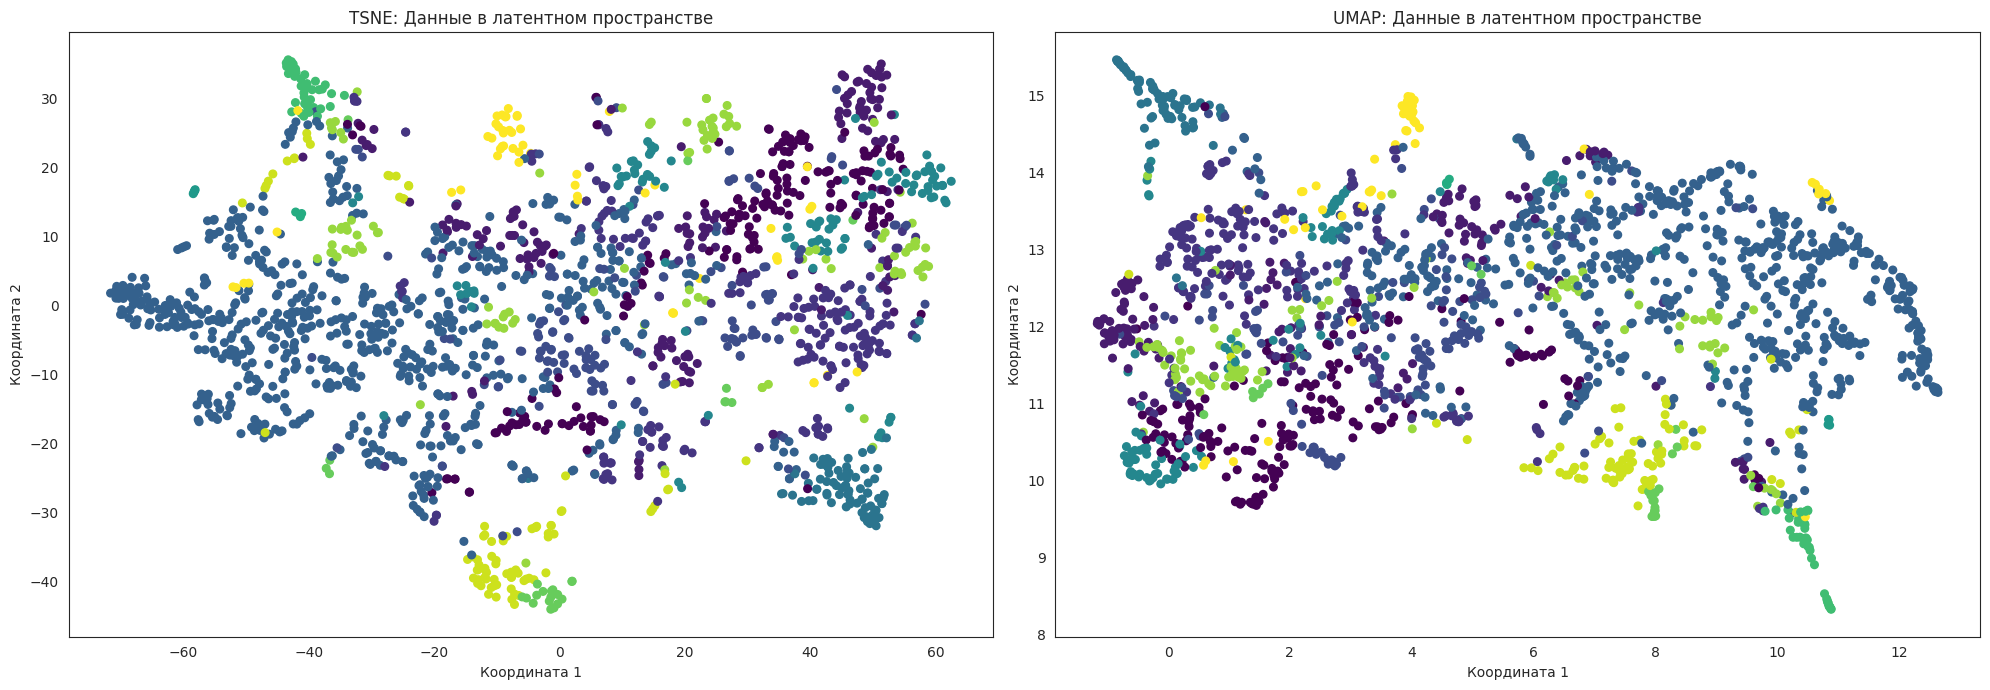

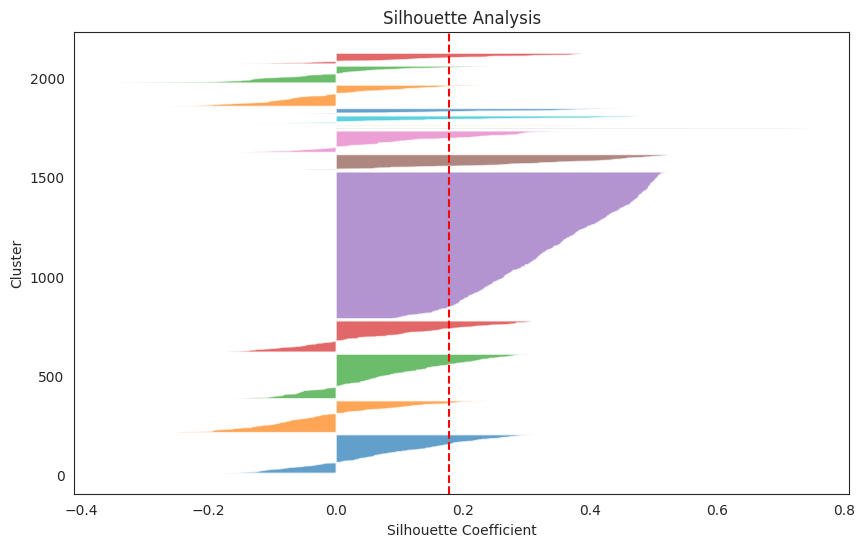

Silhouette Score for KMeans: 0.17821822044485838


In [218]:
kmeans_visualize(n_clusters=14)

**Вывод:**

**Параметры:** n_clusters = 14.

**Silhouette Score:** 0.1782 — выше, чем у иерархической кластеризации, но значительно ниже, чем у DBSCAN.

**Анализ результатов:** Метод KMeans смог разбить данные на 14 кластеров с более высокими, но все же умеренными показателями силуэта. Вероятно, это связано с тем, что KMeans лучше подходит для данных с простыми сферическими кластерами и может не справиться с более сложной структурой данных.

**Заключение:** KMeans дал приемлемые результаты, но уступает DBSCAN. Он может быть полезен для грубого разбиения данных, но в случае сложных распределений его следует рассматривать осторожно. Но зато он работает быстрее всех.

**Общий вывод:**

DBSCAN показал себя лучшим методом для данной задачи, обеспечив максимальный силуэтный коэффициент, что указывает на наибольшую плотность и однородность кластеров. Агломеративная кластеризация и KMeans показали более низкие результаты по силуэту, и хотя KMeans смог создать четкие кластеры, его силуэтный коэффициент остается на среднем уровне. Иерархическая кластеризация показала слабые результаты и потребует дальнейших доработок для повышения качества кластеризации. Но с точки зрения учебной задачи, мы поняли, что параметры нужно настраивать очень долго, для достижения лучшего качества модели.